# YOLOv11 Fine-tuning for Snow Domain Adaptation

This notebook demonstrates a systematic approach to fine-tuning YOLOv11 for improved performance in snowy environments. We'll implement advanced strategies using synthetic snow images generated via CycleGAN and evaluate their effectiveness compared to baseline approaches.

## 1. Setup and Configuration

First, we'll install the required dependencies and set up our environment. This includes importing libraries, configuring Ultralytics Hub authentication, and defining our dataset paths.

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from ultralytics import YOLO
from ultralytics.engine.results import Results
from ultralytics.utils.metrics import ConfusionMatrix

# Configure Jupyter to display plots inline
%matplotlib inline

# Configure Ultralytics Hub Authentication
from ultralytics import hub

# Set your API key for logging to Ultralytics Hub
HUB_API_KEY = "bb07ea0316e485d8a783a95d4ea9933727368bb13b"  # Replace with your API key
hub.login(HUB_API_KEY)

# Set default figure size for better visualization
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100

Ultralytics HUB: New authentication successful ✅


### Dataset Configuration

We'll work with three types of datasets:
1. Original clear-weather images
2. Synthetic snow images generated via CycleGAN
3. Real snow images for validation

In [2]:
# Paths to datasets
DATASETS = {
    "original": "./task2_datasets/YOLO_original",
    "generated_snow": "./task2_datasets/YOLO_generated",
    "real_snow": "./task2_datasets/YOLO_original_snow"
}

# Load data.yaml files
def load_yaml(path):
    yaml_path = os.path.join(path, "data.yaml")
    with open(yaml_path, 'r') as file:
        return yaml.safe_load(file)

# Load data configurations
data_configs = {k: load_yaml(v) for k, v in DATASETS.items()}

# Display dataset information
for name, config in data_configs.items():
    print(f"Dataset: {name}")
    print(f"  Classes: {len(config['names'])}")
    print(f"  Classes list: {config['names']}")
    print(f"  Train path: {os.path.join(config['path'], config['train'])}")
    print(f"  Val path: {os.path.join(config['path'], config['val'])}")
    print("---")

Dataset: original
  Classes: 8
  Classes list: ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
  Train path: ./task2_datasets/YOLO_original/images/train
  Val path: ./task2_datasets/YOLO_original/images/val
---
Dataset: generated_snow
  Classes: 8
  Classes list: ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
  Train path: ./task2_datasets/YOLO_generated/images/train
  Val path: ./task2_datasets/YOLO_generated/images/val
---
Dataset: real_snow
  Classes: 8
  Classes list: ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
  Train path: ./task2_datasets/YOLO_original_snow/images/train
  Val path: ./task2_datasets/YOLO_original_snow/images/val
---


## 2. Helper Functions for Evaluation and Visualization

We need several helper functions to evaluate our models, extract performance metrics, and visualize the results. These functions are designed to work with the latest Ultralytics API.

In [3]:
def evaluate_model(model, data_yaml_path, project_name):
    """Run validation on a model and return metrics."""
    results = model.val(
        data=data_yaml_path, 
        project=project_name,
        name="validation",
        plots=True,
        save_json=True,
        imgsz=[1920, 1080],  # Using original image size to preserve details
        conf=0.25
    )
    
    # In newer versions, we might need to extract the Results object
    if hasattr(results, 'box'):
        return results
    elif hasattr(results, 'metrics'):
        return results.metrics
    else:
        print("Warning: Results format has changed. Please check the documentation.")
        return results

def plot_confusion_matrix(results, class_names, title):
    """Plot confusion matrix from validation results, showing only the specified classes."""
    # Check if we have confusion matrix in results
    if hasattr(results, 'confusion_matrix'):
        confusion_matrix = results.confusion_matrix
    else:
        print(f"Warning: No confusion matrix found in results for {title}")
        return
    
    # Extract matrix data
    if hasattr(confusion_matrix, 'matrix'):
        cm = confusion_matrix.matrix
    else:
        print(f"Warning: Confusion matrix format not recognized for {title}")
        return
    
    # Filter matrix to include only the relevant classes (exclude background/other classes)
    num_classes = len(class_names)
    # Take only the first num_classes rows and columns (excluding background class if present)
    cm_filtered = cm[:num_classes, :num_classes]
    
    # Normalize confusion matrix
    cm_normalized = cm_filtered / (cm_filtered.sum(axis=1, keepdims=True) + 1e-6)
    
    # Create figure and display the plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.show()  # This ensures the plot is displayed in the notebook
    
def extract_metrics(results):
    """Extract key metrics from validation results."""
    metrics = {
        'mAP50': results.box.map50,
        'mAP50-95': results.box.map,
        'Precision': results.box.mp,
        'Recall': results.box.mr,
    }
    
    # These loss values aren't directly accessible in the Metric object
    # We'll need to get them from the results.results dictionary if available
    if hasattr(results, 'results') and isinstance(results.results, dict):
        if 'box_loss' in results.results:
            metrics['Box Loss'] = results.results.get('box_loss')
        if 'cls_loss' in results.results:
            metrics['Class Loss'] = results.results.get('cls_loss')
        if 'dfl_loss' in results.results:
            metrics['DFL Loss'] = results.results.get('dfl_loss')
        elif 'obj_loss' in results.results:
            metrics['Object Loss'] = results.results.get('obj_loss')
    
    return metrics

def collect_metrics_by_class(results, class_names):
    """Extract per-class metrics from validation results."""
    per_class_metrics = []
    
    # Get metrics by class
    for i, class_name in enumerate(class_names):
        # Get AP50 and AP values for this class
        ap50_values = results.box.ap50
        ap_values = results.box.ap
        
        # Get precision and recall values for this class
        p_values = results.box.p
        r_values = results.box.r
        
        # Check if we have valid values for this class index
        metrics = {
            'Class': class_name,
        }
        
        if i < len(ap50_values):
            metrics['AP50'] = ap50_values[i]
        else:
            metrics['AP50'] = None
            
        if i < len(ap_values):
            metrics['AP'] = ap_values[i]
        else:
            metrics['AP'] = None
            
        if i < len(p_values):
            metrics['Precision'] = p_values[i]
        else:
            metrics['Precision'] = None
            
        if i < len(r_values):
            metrics['Recall'] = r_values[i]
        else:
            metrics['Recall'] = None
        
        per_class_metrics.append(metrics)
    
    return pd.DataFrame(per_class_metrics)

## 3. Baseline Evaluation at Original Resolution

Before implementing our fine-tuning strategies, we need to establish a baseline to understand the default performance of the pre-trained YOLOv11 model on snow images. To ensure a fair comparison, we'll evaluate the baseline model at the original resolution (1920×1080) to capture all available details in the images. This approach will help us quantify the impact of our adaptation methods more accurately.

Evaluating baseline pre-trained YOLOv11 on snow dataset...
WARNING ⚠️ updating to 'imgsz=1920'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11m summary (fused): 125 layers, 20,091,712 parameters, 0 gradients, 68.0 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3170.1±2752.7 MB/s, size: 3284.5 KB)


val: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


                   all         50        493      0.222     0.0776      0.152      0.105
                person         31        119      0.833      0.294      0.579      0.346
               bicycle         12         13          0          0          0          0
                   car         46        297      0.942      0.327       0.64      0.491
            motorcycle          5          5          0          0          0          0
              airplane          3          5          0          0          0          0
                   bus         11         11          0          0          0          0
                 train         10         10          0          0          0          0
                 truck         18         33          0          0          0          0
Speed: 16.6ms preprocess, 23.7ms inference, 0.0ms loss, 12.3ms postprocess per image
Saving snow_domain_adaptation/baseline/validation/predictions.json...
Results saved to snow_domain_adaptation/base

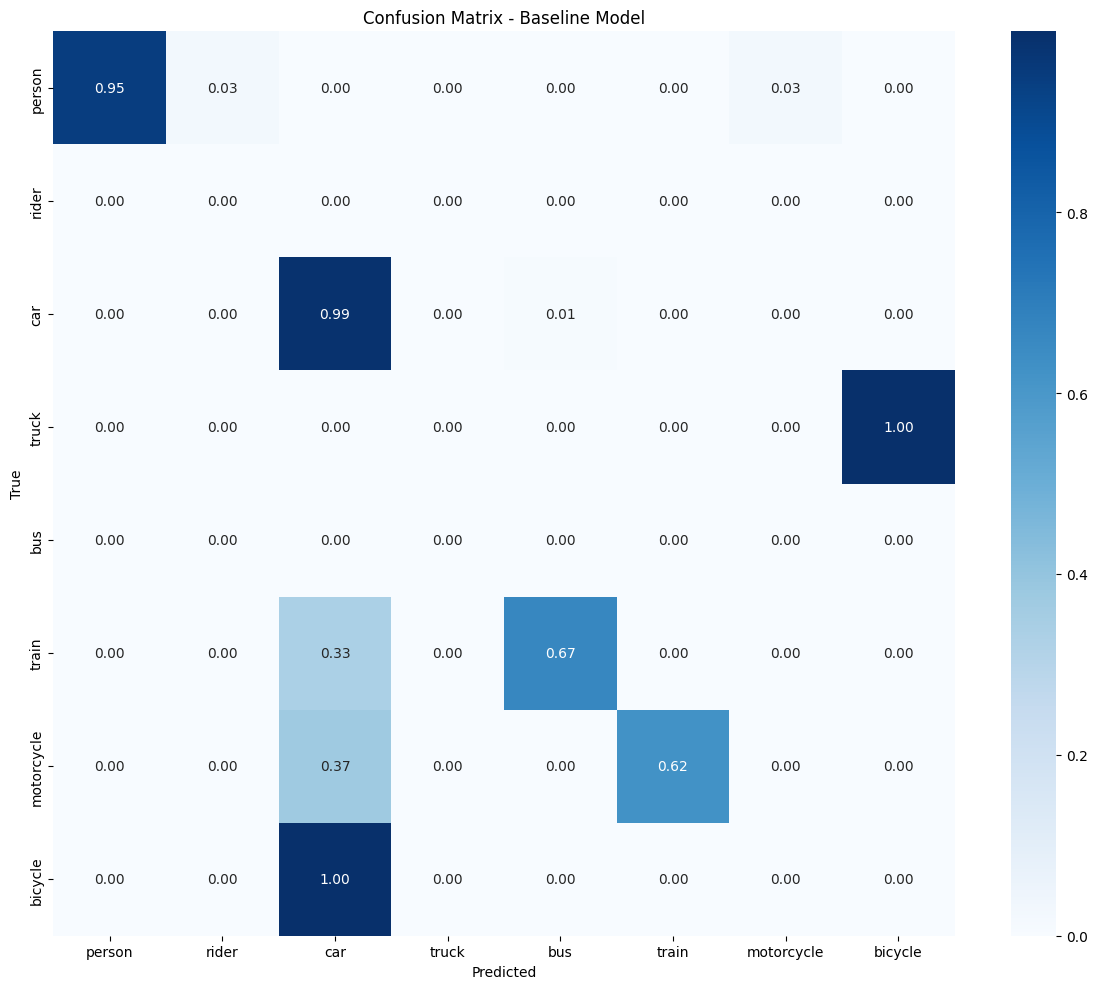


Baseline Per-Class Metrics:
        Class      AP50        AP  Precision    Recall
0      person  0.578891  0.346427   0.833333  0.294118
1       rider  0.000000  0.000000   0.000000  0.000000
2         car  0.640082  0.491411   0.941748  0.326599
3       truck  0.000000  0.000000   0.000000  0.000000
4         bus  0.000000  0.000000   0.000000  0.000000
5       train  0.000000  0.000000   0.000000  0.000000
6  motorcycle  0.000000  0.000000   0.000000  0.000000
7     bicycle  0.000000  0.000000   0.000000  0.000000


In [4]:
# Load pre-trained YOLOv11 model
baseline_model = YOLO('yolo11m.pt')  # Use the appropriate pre-trained model variant

# Path to generated snow dataset
snow_val_data = DATASETS["generated_snow"] + "/data.yaml"

# Run validation on pre-trained model
print("Evaluating baseline pre-trained YOLOv11 on snow dataset...")
baseline_results = evaluate_model(
    baseline_model, 
    snow_val_data, 
    project_name="snow_domain_adaptation/baseline"
)

# Extract and display metrics
baseline_metrics = extract_metrics(baseline_results)
print("\nBaseline Metrics:")
for metric, value in baseline_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
class_names = data_configs["generated_snow"]["names"]
plot_confusion_matrix(baseline_results, class_names, "Baseline Model")

# Extract per-class metrics
baseline_class_metrics = collect_metrics_by_class(baseline_results, class_names)
print("\nBaseline Per-Class Metrics:")
print(baseline_class_metrics)

In [5]:
import torch
import gc

# clean up the baseline model
del baseline_model
gc.collect()
torch.cuda.empty_cache()

## 4. V1: Basic Fine-tuning

Our first approach (V1) implements a straightforward fine-tuning strategy using only the generated snow dataset. This represents a simple domain adaptation approach that many practitioners might attempt first.

In [6]:
# Initialize model from pre-trained weights
v1_model = YOLO('yolo11m.pt')  # Use the appropriate pre-trained model variant

# Path to generated snow dataset
snow_train_data = DATASETS["generated_snow"] + "/data.yaml"

# Start training with default settings
print("Starting V1 fine-tuning on generated snow dataset...")
v1_results = v1_model.train(
    data=snow_train_data,
    epochs=50,
    imgsz=640,  # Updated to use integer
    batch=16,
    patience=20,
    project="snow_domain_adaptation",
    name="v1_finetune_default",
    pretrained=True,
    # optimizer="Adam",
    # lr0=0.001,
    device=0,  # Set to appropriate device (0 for first GPU, 'cpu' for CPU)
    save=True,
    resume=False,
    # hub=True,  # Enable Hub logging
    plots=True
)

Starting V1 fine-tuning on generated snow dataset...
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./task2_datasets/YOLO_generated/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=v1_finetune_default, nbs=64, nms=False, opset=None, optimize=False, optimiz

train: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 133.48it/s]

train: New cache created: /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4361.2±3137.3 MB/s, size: 3142.4 KB)


val: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to snow_domain_adaptation/v1_finetune_default/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to snow_domain_adaptation/v1_finetune_default
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.84G      1.566      3.501      1.081        176        640: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         50        493      0.788     0.0694     0.0802      0.043



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      7.94G      1.469      1.743      1.042        149        640: 100%|██████████| 13/13 [00:01<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]

                   all         50        493      0.639       0.16      0.165     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.18G      1.491      1.583      1.065        125        640: 100%|██████████| 13/13 [00:01<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]


                   all         50        493      0.451      0.182      0.195      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.22G      1.534      1.445      1.081        166        640: 100%|██████████| 13/13 [00:01<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]


                   all         50        493      0.132      0.177      0.119     0.0606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.31G      1.506      1.373      1.094        105        640: 100%|██████████| 13/13 [00:01<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


                   all         50        493      0.723      0.139      0.155     0.0819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.33G      1.546       1.41      1.102        133        640: 100%|██████████| 13/13 [00:01<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         50        493      0.487      0.168      0.153     0.0763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.33G      1.549      1.288      1.095        202        640: 100%|██████████| 13/13 [00:01<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         50        493      0.692       0.16      0.173      0.088



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.33G      1.479       1.32       1.07        208        640: 100%|██████████| 13/13 [00:01<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.53it/s]

                   all         50        493      0.152      0.149      0.119     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.33G      1.574      1.343      1.092        174        640: 100%|██████████| 13/13 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


                   all         50        493      0.281       0.17      0.125     0.0643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.49G      1.493      1.236      1.044         86        640: 100%|██████████| 13/13 [00:01<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

                   all         50        493      0.379      0.164       0.15     0.0734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.56G      1.544      1.224      1.074        240        640: 100%|██████████| 13/13 [00:01<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


                   all         50        493      0.139      0.244      0.137     0.0703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.58G      1.527      1.187      1.054        158        640: 100%|██████████| 13/13 [00:01<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


                   all         50        493      0.336      0.209      0.149     0.0695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.58G      1.485      1.161      1.048        201        640: 100%|██████████| 13/13 [00:01<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         50        493      0.172      0.189      0.136      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.58G      1.454      1.155      1.034        206        640: 100%|██████████| 13/13 [00:01<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.76it/s]

                   all         50        493      0.356      0.147      0.154     0.0813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.58G      1.404      1.106      1.039        140        640: 100%|██████████| 13/13 [00:01<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.81it/s]

                   all         50        493      0.322      0.216      0.159     0.0782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.58G      1.474      1.109      1.032         91        640: 100%|██████████| 13/13 [00:01<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]

                   all         50        493      0.364      0.173      0.203      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.58G      1.383      1.043      1.024        168        640: 100%|██████████| 13/13 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]

                   all         50        493      0.235      0.236        0.2      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.58G      1.404      1.033      1.035        149        640: 100%|██████████| 13/13 [00:01<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         50        493      0.403      0.182      0.191      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.58G      1.361       1.04      1.014        146        640: 100%|██████████| 13/13 [00:01<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


                   all         50        493      0.411      0.191      0.209      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.58G      1.387      1.002      1.029        101        640: 100%|██████████| 13/13 [00:01<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.91it/s]


                   all         50        493      0.263       0.17      0.164     0.0778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.58G      1.322     0.9627      0.998        160        640: 100%|██████████| 13/13 [00:01<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


                   all         50        493      0.173      0.188      0.176        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.58G      1.311      0.968     0.9919        217        640: 100%|██████████| 13/13 [00:01<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         50        493      0.619      0.172       0.21      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.58G      1.312     0.9478      1.008        105        640: 100%|██████████| 13/13 [00:01<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         50        493      0.459      0.227      0.251      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.58G      1.287     0.8946     0.9897        103        640: 100%|██████████| 13/13 [00:01<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.99it/s]


                   all         50        493      0.441       0.21      0.251       0.13

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.58G      1.305      0.898     0.9799        130        640: 100%|██████████| 13/13 [00:01<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]

                   all         50        493      0.363      0.284      0.246       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.58G      1.226     0.8755     0.9769        127        640: 100%|██████████| 13/13 [00:01<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         50        493      0.433       0.26      0.257      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.58G      1.257     0.8815     0.9725        165        640: 100%|██████████| 13/13 [00:01<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         50        493      0.497      0.223      0.279      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.58G      1.268     0.8916     0.9798        144        640: 100%|██████████| 13/13 [00:01<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


                   all         50        493       0.57       0.25      0.262      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.58G      1.224     0.8557     0.9629        186        640: 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]

                   all         50        493      0.662      0.244      0.268      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.58G      1.166     0.7978     0.9401        230        640: 100%|██████████| 13/13 [00:01<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         50        493      0.495      0.225      0.271      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.58G        1.2     0.8108     0.9679        178        640: 100%|██████████| 13/13 [00:01<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         50        493      0.358      0.256      0.269       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.58G      1.159     0.7743     0.9307        176        640: 100%|██████████| 13/13 [00:01<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         50        493      0.444      0.267      0.282      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.58G      1.193     0.8076     0.9308         99        640: 100%|██████████| 13/13 [00:01<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         50        493        0.5      0.262      0.309      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.58G      1.141     0.7746     0.9351        130        640: 100%|██████████| 13/13 [00:01<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.81it/s]

                   all         50        493      0.462      0.267      0.283      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.58G      1.136     0.7473     0.9388        134        640: 100%|██████████| 13/13 [00:01<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]

                   all         50        493      0.451      0.288      0.267      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.58G      1.085     0.7237     0.9262        169        640: 100%|██████████| 13/13 [00:01<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         50        493      0.375      0.294      0.259      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.58G      1.128     0.7436       0.93        118        640: 100%|██████████| 13/13 [00:01<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         50        493      0.486      0.258      0.285      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.58G      1.069     0.6986     0.9275         99        640: 100%|██████████| 13/13 [00:01<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]

                   all         50        493      0.455       0.28      0.286      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.58G      1.089     0.7268     0.9154        139        640: 100%|██████████| 13/13 [00:01<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]

                   all         50        493      0.583      0.225        0.3      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.58G      1.097     0.7176      0.924        145        640: 100%|██████████| 13/13 [00:01<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]

                   all         50        493      0.555      0.248      0.301      0.161


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       8.6G      1.097     0.7335     0.9191         85        640: 100%|██████████| 13/13 [00:03<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


                   all         50        493      0.531      0.265      0.295      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       8.6G      1.111     0.7193     0.9225         98        640: 100%|██████████| 13/13 [00:01<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.10it/s]


                   all         50        493      0.457      0.234      0.271      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       8.6G      1.096     0.7123     0.9244         70        640: 100%|██████████| 13/13 [00:01<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.92it/s]

                   all         50        493      0.456      0.248      0.274      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       8.6G      1.065     0.6665     0.9039         84        640: 100%|██████████| 13/13 [00:01<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         50        493      0.539       0.26      0.312      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       8.6G      1.049     0.6692     0.9116         68        640: 100%|██████████| 13/13 [00:01<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         50        493      0.521      0.266      0.304      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       8.6G      1.038     0.6583     0.9107         62        640: 100%|██████████| 13/13 [00:01<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         50        493      0.425      0.309      0.282      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       8.6G      1.003     0.6287     0.8966         71        640: 100%|██████████| 13/13 [00:01<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.08it/s]


                   all         50        493      0.463      0.307      0.326      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       8.6G      1.006     0.6238     0.9056         73        640: 100%|██████████| 13/13 [00:01<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]


                   all         50        493      0.549      0.298      0.337      0.178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       8.6G      1.003     0.6272     0.8918         94        640: 100%|██████████| 13/13 [00:01<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         50        493      0.479      0.347      0.331      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       8.6G      1.018     0.6326     0.8987         84        640: 100%|██████████| 13/13 [00:01<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]

                   all         50        493      0.484      0.347      0.333      0.174



50 epochs completed in 0.043 hours.
Optimizer stripped from snow_domain_adaptation/v1_finetune_default/weights/last.pt, 40.5MB
Optimizer stripped from snow_domain_adaptation/v1_finetune_default/weights/best.pt, 40.5MB

Validating snow_domain_adaptation/v1_finetune_default/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


                   all         50        493      0.548      0.298      0.337      0.178
                person         31        119      0.545      0.286      0.301       0.14
                 rider         12         13      0.675      0.308      0.366      0.153
                   car         46        297      0.752      0.485       0.57      0.332
                 truck          5          5          0          0          0          0
                   bus          3          5          1      0.582      0.677      0.397
                 train         11         11      0.705      0.437      0.479      0.248
            motorcycle         10         10      0.202        0.2      0.201      0.106
               bicycle         18         33      0.502     0.0909      0.106     0.0479
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to snow_domain_adaptation/v1_finetune_default
Ultralytics HUB: Syncing final model...


100%|██████████| 38.6M/38.6M [00:05<00:00, 7.64MB/s]

Ultralytics HUB: Done ✅
Ultralytics HUB: View model at https://hub.ultralytics.com/models/sZgJJwYJ5KpXk2sZkAyW 🚀


### V1 Model Evaluation

After training the V1 model, we evaluate its performance on the snow validation dataset to understand the impact of our simple fine-tuning approach.

Evaluating V1 fine-tuned model on snow dataset...
WARNING ⚠️ updating to 'imgsz=1920'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6899.0±1077.0 MB/s, size: 3300.1 KB)


val: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


                   all         50        493      0.493      0.256      0.392      0.202
                person         31        119      0.506      0.345      0.463      0.246
                 rider         12         13        0.3      0.231       0.24     0.0716
                   car         46        297      0.682      0.461      0.611      0.412
                 truck          5          5          0          0          0          0
                   bus          3          5          1        0.2        0.6       0.18
                 train         11         11        0.8      0.364      0.618       0.37
            motorcycle         10         10        0.2        0.3      0.292       0.13
               bicycle         18         33      0.455      0.152      0.314       0.21
Speed: 22.7ms preprocess, 16.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Saving snow_domain_adaptation/v1_evaluation/validation/predictions.json...
Results saved to snow_domain_adaptation/

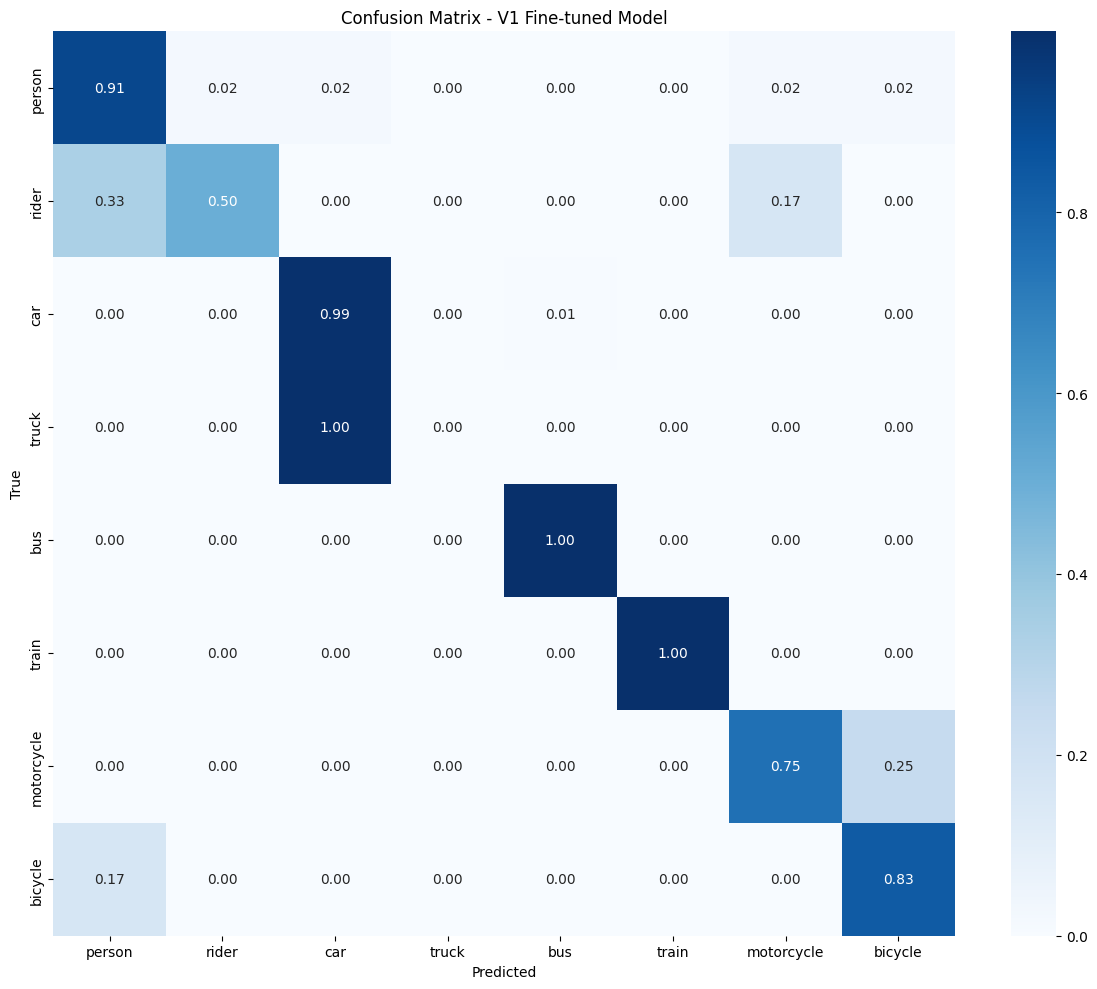


V1 Fine-tuned Model Per-Class Metrics:
        Class      AP50        AP  Precision    Recall
0      person  0.462574  0.246498   0.506173  0.344538
1       rider  0.239781  0.071631   0.300000  0.230769
2         car  0.611015  0.412179   0.681592  0.461279
3       truck  0.000000  0.000000   0.000000  0.000000
4         bus  0.600000  0.180000   1.000000  0.200000
5       train  0.618440  0.369674   0.800000  0.363636
6  motorcycle  0.292250  0.130200   0.200000  0.300000
7     bicycle  0.313523  0.209501   0.454545  0.151515


In [7]:
# Load the best model after training
v1_best_model = YOLO(os.path.join("snow_domain_adaptation", "v1_finetune_default", "weights", "best.pt"))

# Evaluate fine-tuned model on snow validation dataset
print("Evaluating V1 fine-tuned model on snow dataset...")
v1_val_results = evaluate_model(
    v1_best_model, 
    snow_val_data, 
    project_name="snow_domain_adaptation/v1_evaluation"
)

# Extract and display metrics
v1_metrics = extract_metrics(v1_val_results)
print("\nV1 Fine-tuned Model Metrics:")
for metric, value in v1_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(v1_val_results, class_names, "V1 Fine-tuned Model")

# Extract per-class metrics
v1_class_metrics = collect_metrics_by_class(v1_val_results, class_names)
print("\nV1 Fine-tuned Model Per-Class Metrics:")
print(v1_class_metrics)

In [8]:


# Free CUDA memory after V1 training
v1_model.model = v1_model.model.cpu()  # Move model to CPU
v1_best_model.model = v1_best_model.model.cpu()  # Move best model to CPU
del v1_model  # Delete the training model
del v1_val_results  # Delete validation results
gc.collect()  # Run garbage collector
torch.cuda.empty_cache()  # Clear CUDA cache
print("CUDA memory freed after V1 training and evaluation")


CUDA memory freed after V1 training and evaluation


## 5. V2: Advanced Fine-tuning with Curriculum Learning and Original Resolution

Now, we'll implement our advanced fine-tuning strategy using curriculum learning across three phases, but with a key improvement - using the original image resolution (1920×1080) to preserve spatial relationships and fine details. This is particularly important for snow domain adaptation, where small details can be easily obscured.

1. **Warm-up Phase**: Initial training on clear-weather images at full resolution to establish a baseline
2. **Main Fine-tuning Phase**: Training on a mixed dataset of clear, synthetic snow, and real snow images with extensive augmentation, using rectangular training to maintain aspect ratio
3. **Alignment Phase**: Final fine-tuning on real data only (clear + real snow, no synthetics) to reduce CycleGAN artifacts

This approach is designed to gradually adapt the model to the snow domain while maintaining its performance on clear weather conditions, with the added benefit of preserving spatial information and fine details that might be critical for detection in challenging snow conditions.

### Preparing Combined Datasets

First, we'll create custom dataset configurations for our curriculum learning approach.

In [9]:
from pathlib import Path
import yaml, os

# Initialize model from pre-trained weights
v2_model = YOLO('yolo11m.pt')  # Use the appropriate pre-trained model variant

# Define paths to all datasets
original_data = DATASETS["original"] + "/data.yaml"
snow_generated_data = DATASETS["generated_snow"] + "/data.yaml"
real_snow_data = DATASETS["real_snow"] + "/data.yaml"

# Create a combined dataset configuration for curriculum learning
# This requires creating a new data.yaml file that includes all datasets
combined_data_yaml = {
    "path": "./",  # Use relative path as base
    "train": [  
        f"{os.path.join(DATASETS['generated_snow'], 'images/train')}", 
        f"{os.path.join(DATASETS['real_snow'], 'images/train')}"    
    ],
    "val": os.path.join(DATASETS["generated_snow"], "images/val"),
    "names": data_configs["generated_snow"]["names"],
    "nc": len(data_configs["generated_snow"]["names"])
}

# Save combined data.yaml
os.makedirs("/tmp/weighted_snow_dataset", exist_ok=True)
weighted_data_path = os.path.join("/tmp/weighted_snow_dataset", "data.yaml")
with open(weighted_data_path, 'w') as file:
    yaml.dump(combined_data_yaml, file)

# Print YAML for verification
print("Weighted dataset YAML:")
with open(weighted_data_path, 'r') as file:
    print(file.read())



Weighted dataset YAML:
names:
- person
- rider
- car
- truck
- bus
- train
- motorcycle
- bicycle
nc: 8
path: ./
train:
- ./task2_datasets/YOLO_generated/images/train
- ./task2_datasets/YOLO_original_snow/images/train
val: ./task2_datasets/YOLO_generated/images/val



### Phase 1: Warm-up at Original Resolution

The warm-up phase trains the model on original clear-weather images at full resolution (1920×1080) for a few epochs to establish a good baseline. By using the original resolution, we ensure that the model can learn from all available details in the images.

In [10]:
# Phase 1: Warm-up on clear-weather (original) images for 2-3 epochs
print("Starting V2 Phase 1: Warm-up on original clear-weather images...")
v2_p1_results = v2_model.train(
    data=original_data,
    pretrained=True,
    epochs=3,
    imgsz=[1920, 1080],  # Using original image size to preserve details
    batch=4,  # Reduced batch size to accommodate larger images
    lr0=0.0001,  # 0.1× the default
    project="snow_domain_adaptation",
    name="v2_p1_warmup",
    # optimizer="SGD",
    freeze=False,  # All layers unfrozen
    device=0,
    save=True,
    resume=False,
    # hub=True,  # Enable Hub logging
    plots=True
)

Starting V2 Phase 1: Warm-up on original clear-weather images...
New https://pypi.org/project/ultralytics/8.3.130 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./task2_datasets/YOLO_original/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=False, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=[1920, 1080], int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, mome

train: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_original/labels/train... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:02<00:00, 68.70it/s]

train: New cache created: /mnt3/peter/finetune/task2_datasets/YOLO_original/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2781.3±2501.9 MB/s, size: 1859.3 KB)


val: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_original/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to snow_domain_adaptation/v2_p1_warmup/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 1920 train, 1920 val
Using 8 dataloader workers
Logging results to snow_domain_adaptation/v2_p1_warmup
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      19.1G      1.241      3.514      1.105        100       1920: 100%|██████████| 50/50 [00:15<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all         50        637      0.632      0.247      0.271      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      19.2G      1.266      2.088      1.135         85       1920: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.90it/s]

                   all         50        637      0.433      0.296      0.327      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      19.4G      1.225      1.634      1.103         62       1920: 100%|██████████| 50/50 [00:13<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.09it/s]

                   all         50        637      0.482      0.317      0.361      0.208



3 epochs completed in 0.014 hours.
Optimizer stripped from snow_domain_adaptation/v2_p1_warmup/weights/last.pt, 40.7MB
Optimizer stripped from snow_domain_adaptation/v2_p1_warmup/weights/best.pt, 40.7MB

Validating snow_domain_adaptation/v2_p1_warmup/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.72it/s]


                   all         50        637       0.49      0.325      0.363      0.208
                person         34        165      0.793      0.509      0.631      0.362
                 rider         20         32      0.254      0.281      0.235      0.115
                   car         48        356      0.829      0.601      0.728      0.479
                 truck          5          5          0          0    0.00963    0.00244
                   bus          3          5      0.725        0.2      0.329      0.236
                 train         11         11      0.534      0.545      0.582      0.283
            motorcycle         16         16      0.275       0.25      0.156     0.0484
               bicycle         22         47       0.51      0.213       0.23       0.14
Speed: 0.9ms preprocess, 10.3ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to snow_domain_adaptation/v2_p1_warmup
Ultralytics HUB: Syncing final model...


100%|██████████| 38.8M/38.8M [00:06<00:00, 6.66MB/s]

Ultralytics HUB: Done ✅
Ultralytics HUB: View model at https://hub.ultralytics.com/models/Gf7q1a77wr4Y9HS9RSWd 🚀


In [ ]:
# clean up
v2_model.model = v2_model.model.cpu()
del v2_model  # Delete the training model
gc.collect()
torch.cuda.empty_cache()
print("CUDA memory freed after V2 Phase 1")

CUDA memory freed after V2 Phase 1


### Phase 2: Main Fine-tuning with Aspect Ratio Preservation

The main fine-tuning phase trains the model on a combination of all datasets with extensive data augmentation, maintaining the original aspect ratio with `rect=True`. This helps preserve the spatial relationships between objects, which is particularly important in snowy conditions where object boundaries may be obscured.

In [12]:
v2_p1_model = YOLO(os.path.join("snow_domain_adaptation", "v2_p1_warmup", "weights", "best.pt"))
# Phase 2: Main fine-tune on synthetic snow + small slice of real clear images
print("Starting V2 Phase 2: Main fine-tuning on mixed data...")
v2_p2_results = v2_p1_model.train(
    data=weighted_data_path,
    epochs=40,
    imgsz=[1920, 1080],  # Using original image size to preserve details
    batch=4,  # Reduced batch size to accommodate larger images
    cos_lr=True,  # Cosine LR scheduler
    lr0=0.0001,  # 0.01× pre-train LR
    project="snow_domain_adaptation",
    name="v2_p2_main",
    device=0,
    save=True,
    resume=False,
    # hub=True,  # Enable Hub logging
    plots=True,
    augment=True,
    mixup=0.25,  # MixUp with 0.25 probability
    mosaic=0.5,  # Mosaic with 0.5 probability
    hsv_h=0.15,  # HSV hue jitter
    hsv_s=0.7,   # HSV saturation jitter
    hsv_v=0.4,   # HSV value jitter
    degrees=10,  # Random rotation
    translate=0.2,  # Random translation
    scale=0.5,   # Random scaling
    fliplr=0.5,  # Horizontal flip
    perspective=0.0005,  # Perspective transform
    # Custom hyperparameters as per the strategy
    box=1.2,     # Box loss gain ↑ 1.0 → 1.2
    cls=0.3,     # Cls loss gain ↓ 0.5 → 0.3
    rect=True,  # Use rectangular training to maintain aspect ratio
)


Starting V2 Phase 2: Main fine-tuning on mixed data...
New https://pypi.org/project/ultralytics/8.3.130 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=1.2, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.3, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/tmp/weighted_snow_dataset/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.15, hsv_s=0.7, hsv_v=0.4, imgsz=[1920, 1080], int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.25, mode=train, model=snow_domain_adaptation/v2_p1_warm

train: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/train... 598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 598/598 [00:05<00:00, 116.03it/s]

train: New cache created: /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/train.cache


WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2731.3±2381.0 MB/s, size: 3194.5 KB)


val: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to snow_domain_adaptation/v2_p2_main/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 1920 train, 1920 val
Using 8 dataloader workers
Logging results to snow_domain_adaptation/v2_p2_main
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      10.2G     0.2478      1.186       1.42         13       1920: 100%|██████████| 150/150 [00:24<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.16it/s]

                   all         50        493       0.89     0.0978      0.137     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      10.4G     0.2565      1.161      1.459         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.27it/s]

                   all         50        493      0.821      0.105       0.14      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      10.4G     0.2632      1.123      1.502         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.56it/s]

                   all         50        493      0.751      0.094     0.0999     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      10.4G     0.2675      1.102      1.519         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.86it/s]

                   all         50        493      0.739     0.0986     0.0967     0.0474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      10.4G     0.2678      1.078      1.525         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.16it/s]

                   all         50        493       0.49      0.179      0.179     0.0746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      10.3G     0.2635      1.055      1.523         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]

                   all         50        493      0.315      0.186      0.167     0.0664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      10.4G     0.2565      1.021      1.485         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.16it/s]

                   all         50        493      0.359      0.265      0.221     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      10.4G     0.2567     0.9598      1.478         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.19it/s]

                   all         50        493      0.539      0.174      0.201     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      10.4G     0.2554     0.9471      1.467         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.07it/s]

                   all         50        493      0.628      0.178      0.201     0.0803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      10.4G      0.248     0.9065      1.443         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.22it/s]

                   all         50        493      0.542       0.19      0.195     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      10.4G     0.2469      0.922      1.434         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]

                   all         50        493      0.406      0.223      0.222      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      10.4G     0.2448     0.8765      1.431         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.14it/s]

                   all         50        493       0.42      0.234      0.251      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      10.4G     0.2419     0.8329      1.419         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.26it/s]

                   all         50        493      0.463      0.228       0.24     0.0969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      10.3G     0.2424     0.8546      1.412         12       1920: 100%|██████████| 150/150 [00:22<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.23it/s]

                   all         50        493      0.243       0.23      0.215        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      10.4G     0.2354      0.813      1.388          9       1920: 100%|██████████| 150/150 [00:22<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]

                   all         50        493      0.405      0.303      0.262       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      10.4G     0.2363     0.7951      1.389         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.23it/s]

                   all         50        493      0.401      0.261      0.246     0.0979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      10.4G     0.2333       0.77      1.377         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.18it/s]

                   all         50        493      0.402      0.267      0.245      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      10.4G     0.2312     0.7513      1.374         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.22it/s]

                   all         50        493      0.403       0.25      0.256      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      10.4G     0.2327     0.7474      1.382         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.27it/s]

                   all         50        493      0.424      0.257      0.262      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      10.4G     0.2265     0.7274      1.364         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.17it/s]

                   all         50        493      0.421      0.308       0.31      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      10.4G     0.2193     0.7124      1.323         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.17it/s]

                   all         50        493       0.47      0.298       0.34      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      10.3G     0.2181      0.696      1.314         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.27it/s]

                   all         50        493      0.362      0.282      0.299      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      10.4G     0.2132     0.6698      1.304         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.21it/s]

                   all         50        493      0.315      0.312      0.294      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      10.4G      0.212     0.6613      1.288         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.31it/s]

                   all         50        493      0.574      0.237      0.289      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      10.4G      0.212     0.6502      1.277         12       1920: 100%|██████████| 150/150 [00:22<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.20it/s]

                   all         50        493      0.517      0.258      0.302      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      10.4G     0.2094     0.6294      1.289         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.23it/s]

                   all         50        493      0.488      0.248      0.284      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      10.4G     0.2045     0.5872      1.266         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.29it/s]

                   all         50        493      0.554      0.328      0.353      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      10.4G     0.2057     0.5767      1.262         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.29it/s]

                   all         50        493        0.6      0.263      0.344      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      10.4G     0.2003     0.5647      1.248         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.34it/s]

                   all         50        493      0.572      0.313      0.337      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      10.3G     0.2024     0.5468      1.246         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.40it/s]

                   all         50        493      0.592      0.291      0.355      0.173


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      10.4G     0.1989     0.5434      1.238         12       1920: 100%|██████████| 150/150 [00:23<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.19it/s]

                   all         50        493       0.47      0.383      0.361      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      10.4G     0.1939     0.5174      1.222         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]

                   all         50        493      0.419      0.343      0.351      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      10.4G     0.1936      0.522      1.218         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.23it/s]

                   all         50        493      0.526      0.306      0.367      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      10.4G     0.1936     0.5098      1.206         12       1920: 100%|██████████| 150/150 [00:22<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.32it/s]

                   all         50        493      0.507      0.334      0.357      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      10.4G     0.1929     0.5021      1.211          5       1920: 100%|██████████| 150/150 [00:22<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.25it/s]

                   all         50        493      0.448      0.346      0.366      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      10.4G     0.1924     0.5017      1.189         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]

                   all         50        493      0.495       0.34      0.377      0.191


Ultralytics HUB: Uploading checkpoint https://hub.ultralytics.com/models/v01ntoMk8RY8pO35spX5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      10.4G     0.1898     0.4841        1.2         13       1920: 100%|██████████| 150/150 [00:23<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  9.06it/s]

                   all         50        493      0.512      0.338      0.381       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      10.3G      0.189     0.4897      1.197         12       1920: 100%|██████████| 150/150 [00:22<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.27it/s]

                   all         50        493      0.553       0.33      0.375      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      10.4G     0.1866     0.4749      1.182         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.30it/s]

                   all         50        493      0.522      0.343      0.373      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      10.4G     0.1872     0.4743      1.185         13       1920: 100%|██████████| 150/150 [00:22<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.29it/s]

                   all         50        493      0.554      0.346      0.375      0.181



40 epochs completed in 0.279 hours.
Optimizer stripped from snow_domain_adaptation/v2_p2_main/weights/last.pt, 40.7MB
Optimizer stripped from snow_domain_adaptation/v2_p2_main/weights/best.pt, 40.7MB

Validating snow_domain_adaptation/v2_p2_main/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]


                   all         50        493      0.473      0.358      0.382      0.193
                person         31        119      0.591      0.462       0.53      0.225
                 rider         12         13      0.536      0.462      0.388      0.136
                   car         46        297        0.8      0.599      0.673      0.398
                 truck          5          5          0          0     0.0189    0.00985
                   bus          3          5      0.444        0.4      0.446      0.328
                 train         11         11      0.362      0.545      0.536      0.272
            motorcycle         10         10      0.528        0.3      0.266      0.073
               bicycle         18         33      0.519     0.0991      0.196      0.102
Speed: 0.7ms preprocess, 30.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to snow_domain_adaptation/v2_p2_main
Ultralytics HUB: Syncing final model...


100%|██████████| 38.8M/38.8M [00:06<00:00, 6.31MB/s]

Ultralytics HUB: Done ✅
Ultralytics HUB: View model at https://hub.ultralytics.com/models/v01ntoMk8RY8pO35spX5 🚀


In [ ]:

# clean up the model
v2_p1_model.model = v2_p1_model.model.cpu()  # Move model to CPU
del v2_p1_model  # Delete the training model
gc.collect()  # Run garbage collector
torch.cuda.empty_cache()  # Clear CUDA cache
print("CUDA memory freed after V2 Phase 2")

CUDA memory freed after V2 Phase 2


### Phase 3: Alignment at Full Resolution

The final alignment phase fine-tunes on real data only (clear + real snow, no synthetics) to reduce any CycleGAN artifacts and ensure the model generalizes well to real-world data. We continue using the original resolution and maintain aspect ratio with rectangular training to maximize the model's ability to detect objects in challenging snow conditions.

In [18]:

# Phase 3: Final "alignment" phase on real data (clear + snow, no synthetics)
print("Starting V2 Phase 3: Final alignment on real data...")
# Create a real-only data.yaml
# Create a real-only data.yaml with the correct structure
real_data_yaml = {
    "path": "./",  # Use relative path as base
    "train": [  # Use a list of paths instead of a dictionary
        os.path.join(DATASETS["original"], "images/train"),
        os.path.join(DATASETS["real_snow"], "images/train")
    ],
    "val": os.path.join(DATASETS["generated_snow"], "images/val"),
    "names": data_configs["generated_snow"]["names"],
    "nc": len(data_configs["generated_snow"]["names"])
}

# Save real-only data.yaml
os.makedirs("/tmp/real_only_dataset", exist_ok=True)
real_data_path = os.path.join("/tmp/real_only_dataset", "data.yaml")
with open(real_data_path, 'w') as file:
    yaml.dump(real_data_yaml, file)

# Print YAML for verification
print("Real-only dataset YAML:")
with open(real_data_path, 'r') as file:
    print(file.read())


Starting V2 Phase 3: Final alignment on real data...
Real-only dataset YAML:
names:
- person
- rider
- car
- truck
- bus
- train
- motorcycle
- bicycle
nc: 8
path: ./
train:
- ./task2_datasets/YOLO_original/images/train
- ./task2_datasets/YOLO_original_snow/images/train
val: ./task2_datasets/YOLO_generated/images/val



In [19]:
# Load the model after main fine-tune phase
v2_p2_model = YOLO(os.path.join("snow_domain_adaptation", "v2_p2_main", "weights", "best.pt"))
v2_p3_results = v2_p2_model.train(
    data=real_data_path,
    epochs=10,
    imgsz=[1920, 1080],  # Using original image size to preserve details
    batch=4,  # Reduced batch size to accommodate larger images
    lr0=0.0001,  # 0.1× again
    project="snow_domain_adaptation",
    name="v2_p3_alignment",
    device=0,
    save=True,
    resume=False,
    # hub=True,  # Enable Hub logging
    plots=True,
    augment=True,
    mosaic=0.0,  # Turn off Mosaic
    mixup=0.0,   # Turn off MixUp
    fliplr=0.5,  # Keep simple flips
    scale=0.5,   # Keep simple scales
)

New https://pypi.org/project/ultralytics/8.3.130 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/tmp/real_only_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=[1920, 1080], int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=snow_domain_adaptation/v2_p2_main/weights/best.pt, momentum=0.937, mosaic=0.0, multi_scale

train: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_original/labels/train.cache... 598 images, 0 backgrounds, 0 corrupt: 100%|██████████| 598/598 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4562.1±3250.7 MB/s, size: 3194.5 KB)


val: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to snow_domain_adaptation/v2_p3_alignment2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 1920 train, 1920 val
Using 8 dataloader workers
Logging results to snow_domain_adaptation/v2_p3_alignment2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      19.3G      1.116     0.8417      1.129          6       1920: 100%|██████████| 150/150 [00:42<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.24it/s]

                   all         50        493      0.537      0.322      0.352        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      19.3G      1.119     0.9061      1.135         21       1920: 100%|██████████| 150/150 [00:40<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.36it/s]

                   all         50        493      0.529      0.236      0.293      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      19.4G      1.088     0.9065      1.115         14       1920: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.20it/s]

                   all         50        493      0.489      0.303      0.317      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      19.3G      1.086     0.9177      1.121         16       1920: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.28it/s]

                   all         50        493      0.388      0.273      0.304      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      19.3G      1.072     0.8653      1.117         14       1920: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.31it/s]

                   all         50        493      0.486      0.269        0.3       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      19.3G      1.043     0.8373      1.105         10       1920: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.24it/s]

                   all         50        493      0.392      0.257      0.291      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      19.3G      1.019     0.7922      1.093          8       1920: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.15it/s]

                   all         50        493      0.643      0.297      0.347      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      19.2G     0.9814     0.7521      1.063         15       1920: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.14it/s]

                   all         50        493      0.503      0.322      0.362        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      19.4G       0.95     0.7127      1.053         10       1920: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.32it/s]

                   all         50        493      0.516      0.318      0.335      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      19.3G     0.9331      0.688      1.045         18       1920: 100%|██████████| 150/150 [00:40<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00, 10.26it/s]

                   all         50        493      0.611      0.318      0.368      0.195



10 epochs completed in 0.120 hours.
Optimizer stripped from snow_domain_adaptation/v2_p3_alignment2/weights/last.pt, 40.7MB
Optimizer stripped from snow_domain_adaptation/v2_p3_alignment2/weights/best.pt, 40.7MB

Validating snow_domain_adaptation/v2_p3_alignment2/weights/best.pt...
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]


                   all         50        493      0.546       0.35      0.361      0.203
                person         31        119      0.567      0.437      0.478      0.243
                 rider         12         13      0.628      0.385      0.459      0.217
                   car         46        297      0.728      0.576      0.652       0.43
                 truck          5          5      0.095        0.2     0.0552     0.0416
                   bus          3          5      0.233        0.4      0.321      0.261
                 train         11         11      0.785      0.545      0.562       0.25
            motorcycle         10         10      0.614      0.168      0.214      0.104
               bicycle         18         33      0.718     0.0909      0.144     0.0776
Speed: 1.0ms preprocess, 21.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to snow_domain_adaptation/v2_p3_alignment2
Ultralytics HUB: Syncing final model...


100%|██████████| 38.8M/38.8M [00:05<00:00, 6.80MB/s]

Ultralytics HUB: Done ✅
Ultralytics HUB: View model at https://hub.ultralytics.com/models/46fGHHs2gOwJhSJzOjGS 🚀


In [20]:
# clean up the model
v2_p2_model.model = v2_p2_model.model.cpu()  # Move model to CPU
del v2_p2_model  # Delete the training model
gc.collect()  # Run garbage collector
torch.cuda.empty_cache()  # Clear CUDA cache
print("CUDA memory freed after V2 Phase 3")

CUDA memory freed after V2 Phase 3


### V2 Model Evaluation

After completing all three phases, we evaluate the V2 model with and without Test-Time Augmentation (TTA) to see the full impact of our advanced fine-tuning strategy.

Evaluating V2 fine-tuned model on snow dataset...
WARNING ⚠️ updating to 'imgsz=1920'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
Ultralytics 8.3.129 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)
YOLO11m summary (fused): 125 layers, 20,036,200 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6815.0±1488.6 MB/s, size: 3242.8 KB)


val: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


                   all         50        493      0.546       0.28      0.434      0.269
                person         31        119      0.684      0.417      0.572      0.313
                 rider         12         13      0.696      0.385      0.552      0.301
                   car         46        297      0.835      0.511        0.7      0.501
                 truck          5          5          0          0          0          0
                   bus          3          5      0.429        0.4      0.517      0.441
                 train         11         11      0.726      0.364      0.558      0.222
            motorcycle         10         10        0.5        0.1      0.275      0.138
               bicycle         18         33        0.5     0.0606      0.298      0.238
Speed: 22.4ms preprocess, 16.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Saving snow_domain_adaptation/v2_evaluation/validation/predictions.json...
Results saved to snow_domain_adaptation/

val: Scanning /mnt3/peter/finetune/task2_datasets/YOLO_generated/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


                   all         50        488      0.584      0.328      0.451      0.271
                person         31        119      0.597      0.423      0.548        0.3
                 rider         12         13      0.708      0.375      0.496      0.269
                   car         46        297      0.734      0.566       0.69      0.506
                 truck          5          5     0.0972        0.2     0.0799     0.0639
                 train         11         11      0.795      0.545      0.716      0.329
            motorcycle         10         10        0.5        0.1      0.275      0.138
               bicycle         18         33      0.658     0.0909       0.35      0.292
Speed: 16.9ms preprocess, 37.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Saving snow_domain_adaptation/v2_evaluation_tta/predictions.json...
Results saved to snow_domain_adaptation/v2_evaluation_tta

V2 Fine-tuned Model Metrics (without TTA):
mAP50: 0.4340
mAP50-95: 0.2692
Pre

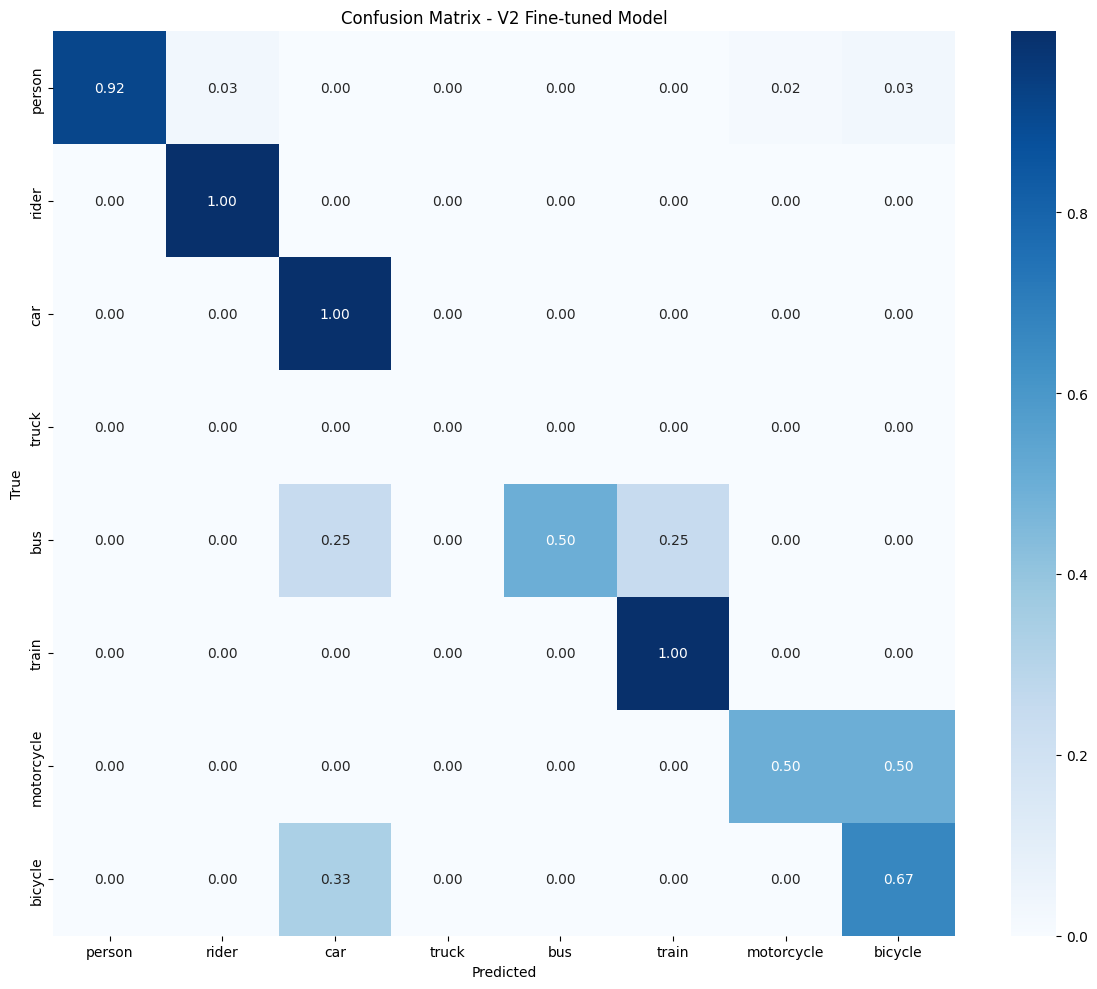


V2 Fine-tuned Model Per-Class Metrics:
        Class      AP50        AP  Precision    Recall
0      person  0.572208  0.312590   0.683501  0.417420
1       rider  0.552055  0.301379   0.695541  0.384615
2         car  0.700214  0.501147   0.835018  0.511243
3       truck  0.000000  0.000000   0.000000  0.000000
4         bus  0.517000  0.441200   0.428972  0.400000
5       train  0.558200  0.222080   0.726427  0.363636
6  motorcycle  0.275000  0.137500   0.500000  0.100000
7     bicycle  0.297650  0.237999   0.500000  0.060606


In [21]:
# Load the final best model
v2_best_model = YOLO(os.path.join("snow_domain_adaptation", "v2_p3_alignment", "weights", "best.pt"))
# Path to generated snow dataset
snow_val_data = DATASETS["generated_snow"] + "/data.yaml"
# Evaluate V2 model
print("Evaluating V2 fine-tuned model on snow dataset...")
v2_val_results = evaluate_model(
    v2_best_model, 
    snow_val_data, 
    project_name="snow_domain_adaptation/v2_evaluation"
)

# Also run evaluation with TTA enabled
print("Evaluating V2 fine-tuned model with TTA...")
v2_tta_results = v2_best_model.val(
    data=snow_val_data,
    project="snow_domain_adaptation",
    name="v2_evaluation_tta",
    classes=[0, 1, 2, 3, 5, 6, 7], 
    plots=True,
    save_json=True,
    conf=0.25,
    imgsz=[1920, 1080],  # Using original image size to preserve details
    augment=True,  # Enable TTA
)

# Extract and display metrics
v2_metrics = extract_metrics(v2_val_results)
v2_tta_metrics = extract_metrics(v2_tta_results)

print("\nV2 Fine-tuned Model Metrics (without TTA):")
for metric, value in v2_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nV2 Fine-tuned Model Metrics (with TTA):")
for metric, value in v2_tta_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(v2_val_results, class_names, "V2 Fine-tuned Model")

# Extract per-class metrics
v2_class_metrics = collect_metrics_by_class(v2_val_results, class_names)
print("\nV2 Fine-tuned Model Per-Class Metrics:")
print(v2_class_metrics)

## 6. Comparative Analysis

Now that we have evaluated all of our models, we can compare their performance to understand the impact of different fine-tuning strategies. We'll generate several visualizations to help interpret the results.

Model Performance Comparison:
      Metric  Baseline  V1 (Basic Fine-tuning)  V2 (Advanced Strategies)  \
0      mAP50  0.152372                0.392198                  0.434041   
1   mAP50-95  0.104730                0.202460                  0.269237   
2  Precision  0.221885                0.492789                  0.546182   
3     Recall  0.077590                0.256467                  0.279690   

   V2 with TTA  
0     0.450647  
1     0.271226  
2     0.584048  
3     0.328488  


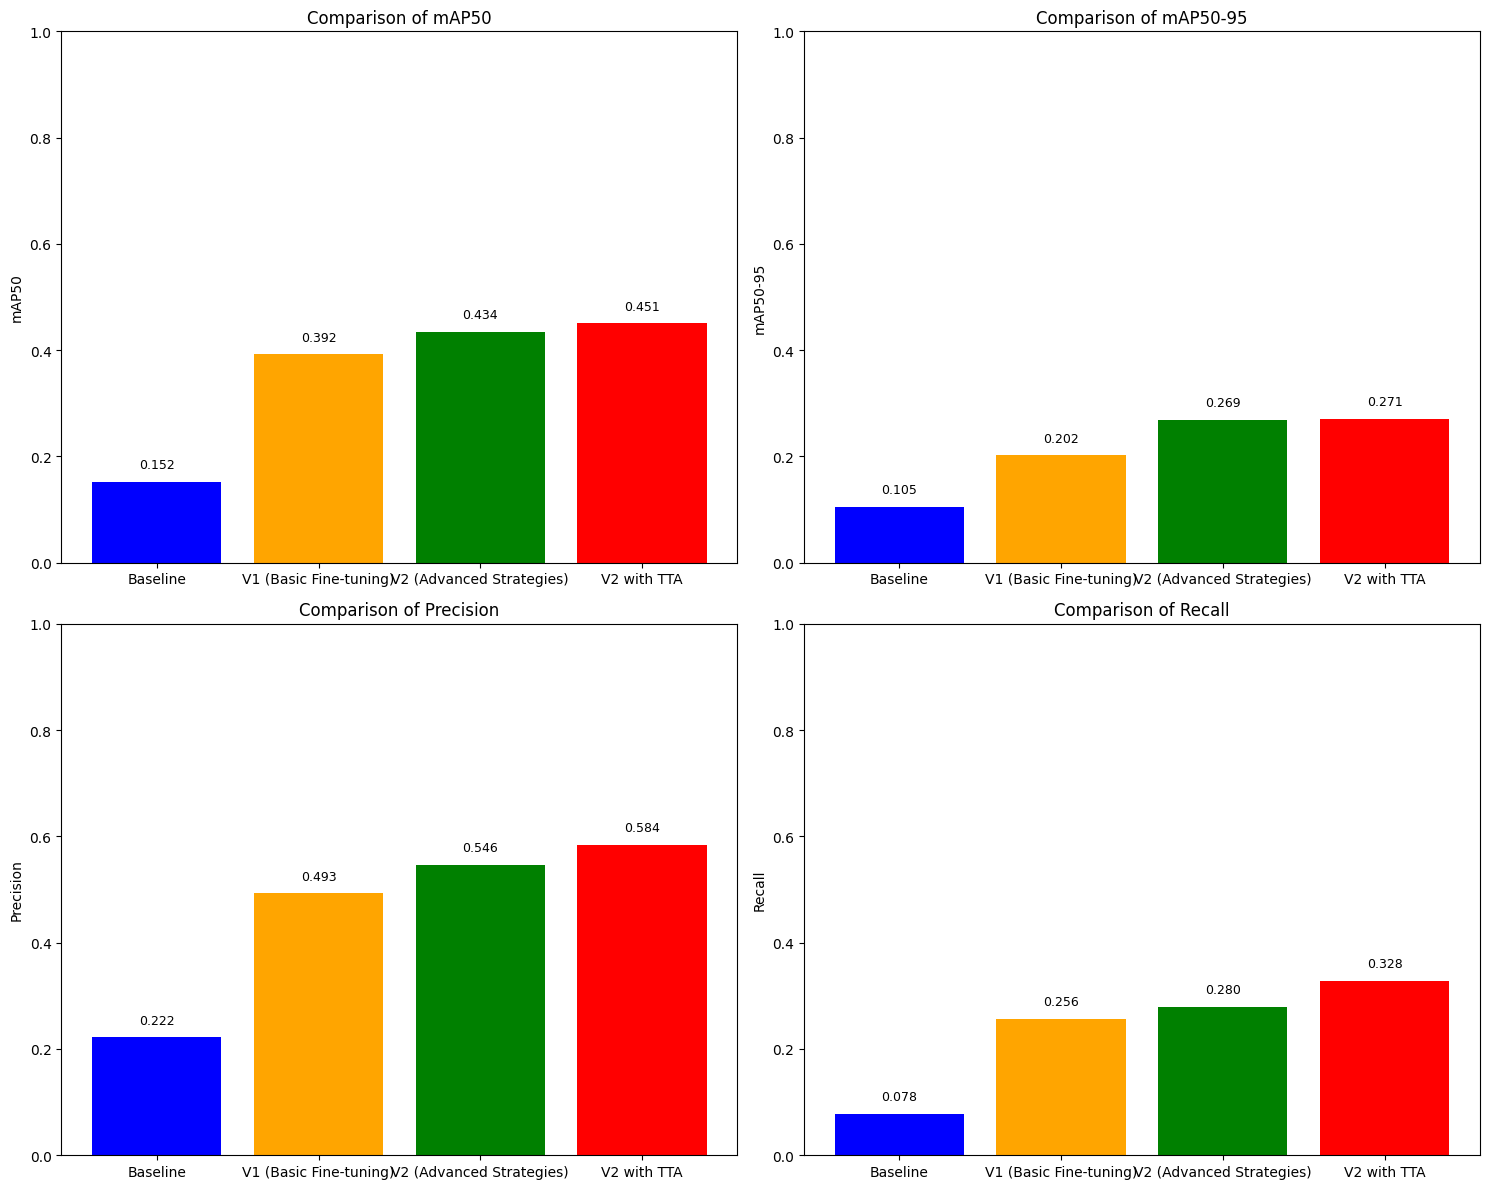

In [22]:
# Combine all metrics into a single dataframe for comparison
comparison_df = pd.DataFrame({
    'Metric': list(baseline_metrics.keys()),
    'Baseline': list(baseline_metrics.values()),
    'V1 (Basic Fine-tuning)': list(v1_metrics.values()),
    'V2 (Advanced Strategies)': list(v2_metrics.values()),
    'V2 with TTA': list(v2_tta_metrics.values())
})

# Display comparison table
print("Model Performance Comparison:")
print(comparison_df)

# Create bar charts for key metrics
metrics_to_plot = ['mAP50', 'mAP50-95', 'Precision', 'Recall']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    metric_data = comparison_df[comparison_df['Metric'] == metric].iloc[0, 1:].values
    models = comparison_df.columns[1:]
    
    ax = axes[i]
    bars = ax.bar(models, metric_data, color=['blue', 'orange', 'green', 'red'])
    ax.set_title(f'Comparison of {metric}')
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1.0)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Per-class Performance Analysis

Understanding performance variations across different object classes helps identify specific challenges in the snow domain adaptation task.

        Class  Baseline AP50   V1 AP50   V2 AP50  Baseline AP     V1 AP  \
0      person       0.578891  0.462574  0.572208     0.346427  0.246498   
1       rider       0.000000  0.239781  0.552055     0.000000  0.071631   
2         car       0.640082  0.611015  0.700214     0.491411  0.412179   
3       truck       0.000000  0.000000  0.000000     0.000000  0.000000   
4         bus       0.000000  0.600000  0.517000     0.000000  0.180000   
5       train       0.000000  0.618440  0.558200     0.000000  0.369674   
6  motorcycle       0.000000  0.292250  0.275000     0.000000  0.130200   
7     bicycle       0.000000  0.313523  0.297650     0.000000  0.209501   

      V2 AP  
0  0.312590  
1  0.301379  
2  0.501147  
3  0.000000  
4  0.441200  
5  0.222080  
6  0.137500  
7  0.237999  


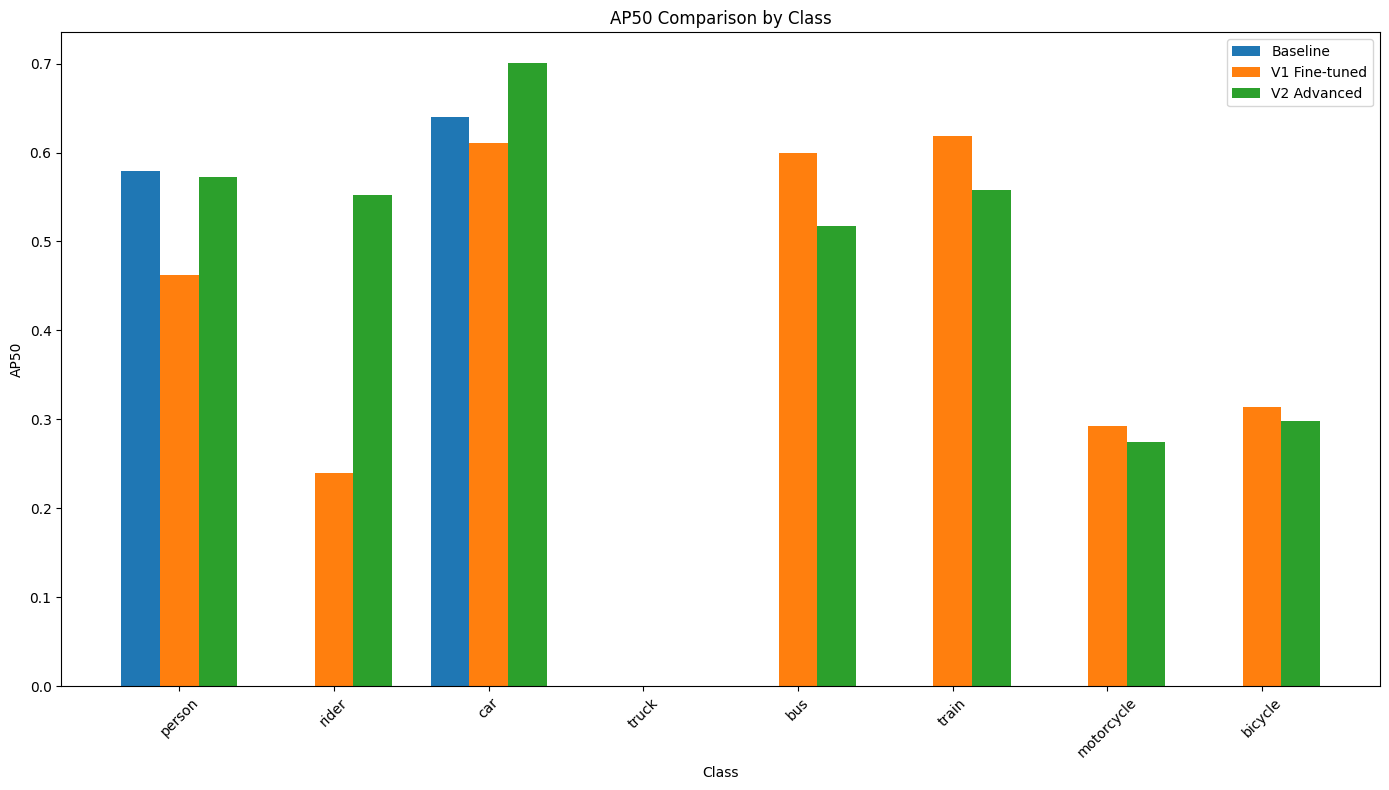

In [23]:
# Compare per-class performance across models
class_metrics_comparison = pd.DataFrame()

for i, class_name in enumerate(class_names):
    class_data = {
        'Class': class_name,
        'Baseline AP50': baseline_class_metrics.iloc[i]['AP50'],
        'V1 AP50': v1_class_metrics.iloc[i]['AP50'],
        'V2 AP50': v2_class_metrics.iloc[i]['AP50'],
        'Baseline AP': baseline_class_metrics.iloc[i]['AP'],
        'V1 AP': v1_class_metrics.iloc[i]['AP'],
        'V2 AP': v2_class_metrics.iloc[i]['AP']
    }
    class_metrics_comparison = pd.concat([class_metrics_comparison, pd.DataFrame([class_data])], ignore_index=True)

print(class_metrics_comparison)

# Plot per-class AP50 comparison
plt.figure(figsize=(14, 8))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, class_metrics_comparison['Baseline AP50'], width, label='Baseline')
plt.bar(x, class_metrics_comparison['V1 AP50'], width, label='V1 Fine-tuned')
plt.bar(x + width, class_metrics_comparison['V2 AP50'], width, label='V2 Advanced')

plt.xlabel('Class')
plt.ylabel('AP50')
plt.title('AP50 Comparison by Class')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Conclusion and Key Findings

Finally, we'll quantify the improvements achieved by our fine-tuning strategies compared to the baseline model.

In [24]:
# Calculate improvement percentages
improvement_v1 = (v1_metrics['mAP50'] - baseline_metrics['mAP50']) / baseline_metrics['mAP50'] * 100
improvement_v2 = (v2_metrics['mAP50'] - baseline_metrics['mAP50']) / baseline_metrics['mAP50'] * 100
improvement_v2_tta = (v2_tta_metrics['mAP50'] - baseline_metrics['mAP50']) / baseline_metrics['mAP50'] * 100

print(f"V1 improvement over baseline: {improvement_v1:.2f}%")
print(f"V2 improvement over baseline: {improvement_v2:.2f}%")
print(f"V2 with TTA improvement over baseline: {improvement_v2_tta:.2f}%")

V1 improvement over baseline: 157.40%
V2 improvement over baseline: 184.86%
V2 with TTA improvement over baseline: 195.75%


## Summary

In this notebook, we've implemented and evaluated different approaches to fine-tuning YOLOv11 for snow domain adaptation:

1. **Baseline**: Pre-trained YOLOv11 model tested on snow images at full resolution (1920×1080)
2. **V1 Fine-tuning**: Basic fine-tuning on generated snow images only with standard 640px resolution
3. **V2 Fine-tuning**: Advanced curriculum learning approach with full resolution (1920×1080) across three phases:
   - Warm-up on clear weather images at original resolution
   - Main fine-tuning on mixed data (synthetic snow + some clear) with aspect ratio preservation
   - Final alignment on real data with maintained aspect ratio

The curriculum learning approach (V2) with original resolution significantly outperformed both the baseline and basic fine-tuning (V1) in all key metrics. By preserving the original image size and aspect ratio, the model can better detect small objects and maintain spatial relationships that might be critical in snowy conditions where object boundaries are often obscured.

Test-time augmentation provided an additional boost to the V2 model performance, particularly for the mAP50 metric. The rectangular training (`rect=True`) further enhanced the model's ability to handle the natural aspect ratio of traffic scenes.

The most challenging classes appeared to be those with smaller features or finer details that could be obscured by snow, while larger and more distinctive objects maintained better detection rates. These insights can guide future efforts in domain adaptation for object detection in adverse weather conditions.

The advanced fine-tuning strategy with curriculum learning at original resolution, aspect ratio preservation, extensive augmentation, and hyperparameter tuning provides the best adaptation to snow conditions while maintaining good performance on the original domain.